이번 포스트는 jupyter notebook으로 jekyll 포스트를 작성하는 방법에 대해 다룹니다. 이 포스트는 주피터 노트북으로 작성되었습니다.

지킬의 장점은 마크다운 파일에 YAML Front Matter만 추가하면 사전 설정된 테마에 따라 멋있는 블로그 포스트를 만들어주기 때문에 별도의 프론트엔드 지식 없이도 손쉽게 블로그 포스트를 만들 수 있다는 것입니다. 하지만, ipynb 파일을 별도의 설정 없이 마크다운으로 변환해 포스트 폴더에 넣는 경우 대참사가 일어나는 것을 볼 수 있는데 이는 기본 변환기가 input과 output을 구분하는 class를 포함하고 있지 않아 전부 코드 블럭으로 표현되고, output의 이미지 경로가 쉽게 꼬인다는 문제입니다. (지킬은 현재 `_posts` 폴더에 png 파일이 포함되는 경우 정상적으로 이미지를 참조하지 못하는 에러가 있습니다. [관련 이슈](https://github.com/jekyll/jekyll/issues/5181))

ipynb 파일을 markdown이나 html로 변환할 때  주피터는 **nbconvert**를 사용합니다. nbconvert는 내부적으로 파이썬의 템플릿 엔진인 **jinja 템플릿**을 사용하는데, nbconvert 사용시에 기본으로 적용되는 템플릿을 수정하고 반영하여 ipynb 파일이 지금 이 글과 같이 블로그 스타일로 변환될 수 있도록 하려고 합니다. 목적에 따라 마크다운 파일이 아닌 html 파일로 변환을 할 수도 있으나, 주로 참조한 [Chris Holdgraf](https://github.com/choldgraf)의 포스트가 마크다운으로 변환하는 방법을 알려주어 이 포스트도 마크다운으로 변환하는 방식을 포스팅했습니다. 목적에 따라 html로 변환해서 포스팅을 하는 것도 물론 가능합니다.

### nbconvert 설치

nbconvert는 `pip install nbconvert`, 콘다 환경인 경우 `conda install nbconvert`를 통해 간단하게 설치할 수 있습니다. 만약 주피터 파일을 html이나 md가 아닌 pdf, tex 등으로 변환하는 등 nbconvert의 모든 기능을 이용하기 위해서는  pandoc 과 XeLaTeX를 추가로 설치해야 합니다. 해당 내용은 [nbconvert 공식문서](https://nbconvert.readthedocs.io/en/latest/install.html)에서 확인하실 수 있습니다.

### nbconvert의 markdown 템플릿 변환하기

nbconvert가 노트북 파일을 마크다운으로 변환할 때 사용하는 템플릿을 커스터마이징하고 싶은 경우 Jinja 템플릿에 대한 이해가 조금은 필요합니다. [Jinja 공식문서](https://jinja.palletsprojects.com/en/2.10.x/templates/)를 읽어볼 수 있으면 좋겠지만, 목적에 비해 그 내용이 방대하므로 [다음의 글](https://www.datacamp.com/community/tutorials/jinja2-custom-export-templates-jupyter)을 참조하시면 간략하게 작동원리를 이해하실 수 있습니다.

nbconvert는 html로 변환하는 경우에는 `basic.tpl`, 마크다운으로 변환하는 경우에는 `markdown.tpl`을 기본값으로 사용하여 렌더링을 합니다. 마크다운으로 변환해 포스팅을 하는 것이 목적이므로, nbconvert 패키지 내에 `markdown.tpl`을 상속받는 `jekyll.tpl`을 다음과 같이 만들었습니다.

[gihub 링크 추가하기!]()

````html
{% extends 'markdown.tpl' %}

{%- block header -%}
---
title: "{{resources['metadata']['name']}}"
search: true
categories:
 - Notebook
tags:
 - Need_modify
last_modified_at: 2999-12-31 23:59
layout: jupyter
classes: wide
---
{%- endblock header -%}

{% block in_prompt %}
<div class="prompt input_prompt">
In&nbsp;[{{ cell.execution_count }}]:
</div>
{% endblock in_prompt %}

{% block input %}
<div class="input_area" markdown="1">
{{ super() }}
</div>
{% endblock input %}

{% block stream %}
{:.output_stream}

```
{{ output.text }}
```
{% endblock stream %}

{% block data_text %}
{:.output_data_text}

```
{{ output.data['text/plain'] }}
```
{% endblock data_text %}

{% block traceback_line  %}
{:.output_traceback_line}

`{{ line | strip_ansi }}`

{% endblock traceback_line  %}

{% block data_html %}
<div markdown="0">
{{ output.data['text/html'] }}
</div>
{% endblock data_html %}

````


위의 템플릿은 [https://predictablynoisy.com/jekyll-markdown-nbconvert] 의 블로그 글을 참고하여 작성하였으며, 반영한 수정사항은 다음과 같습니다.

- YAML Front Matter 양식 헤더에 추가
- input 블록은 기존 템플릿의 변환 방식을 그대로 사용
- output의 텍스트는 `inline code` 양식 사용
- output에 table, image 등 html 코드가 포함된 경우 마크다운으로 렌더링하지 않고 그대로 사용
- input prompt(`In: [0]`)은 살리고, output prompt는 숨기기

그런데 위 템플릿을 이용해 막상 변환을 진행하니 블로그의 테이블 양식이 jupyter의 pandas dataframe을 표현하기에는 조금 부적합하다고 느껴져서 별도의 stylesheet를 작성해주었고, 이를 layout이 jupyter인 경우에만 적용되도록 수정하였습니다.

[github 링크 추가하기!]()

```css
<style type="text/css">
.input_area div.highlighter-rouge {
  background-color: #263238  !important;
}

div.highlighter-rouge, figure.highlight {
  font-size: 0.675em  !important;
}

.output_stream, .output_data_text, .output_traceback_line {
  margin-left: 3% !important;
  border: none !important;
  border-radius: 4px !important;
  background-color: #fafafa !important;
  box-shadow: none !important;
  color: #000000  !important;
  font-size: 0.6em !important;
}

.output_stream:before, .output_data_text:before, .output_traceback_line:before{
  content: none !important;
}

table.dataframe {
    background-color: #fafafa;
    width: 100%;
    max-height: 240px;
    display: block;
    overflow: auto;
    font-family: Arial, sans-serif;
    font-size: 13px;
    line-height: 20px;
    text-align: center;
}
table.dataframe th {
  font-weight: bold;
  padding: 4px;
}
table.dataframe td {
  padding: 4px;
}
table.dataframe tr:hover {
  background: #b8d1f3;
}

</style>

```

### 쉘 함수로 경로 설정 자동화하기

위에서 언급한 `_post`폴더에 png파일이 포함되는 경우 에러가 발생하는 이슈 때문에, 파일에 이미지가 포함되는 경우 그 경로를 모두 `_post` 폴더 바깥으로 바꾼 뒤, 이미지를 모두 옮긴 후, 위에서 작성한 템플릿을 적용해 nbconvert를 실행해야 하는데 그 번거로움이 이만저만이 아닙니다. 그래서, `images` 폴더를 별도로 생성해준 다음에, 이를 자동으로 수행해주는 쉘 함수를(https://blomadam.github.io/tutorials/2017/04/09/ipynb-to-Jekyll-Post-tools.html) 를 참조하여  만들어 `.zshrc`에 추가해 주었습니다. bash를 사용하시는 분들은 `.bash_profile`에 추가해주시면 됩니다.

```sh
function new_post {
    #change these 2 lines to match your specific setup
    POST_PATH="/Users/jungsooyun/Desktop/dev/frontend/jungsooyun.github.io/_posts"
    IMG_PATH="/Users/jungsooyun/Desktop/dev/frontend/jungsooyun.github.io/images"

    FILE_NAME="$1"
    CURR_DIR=`pwd`
    FILE_BASE=`basename $FILE_NAME .ipynb`

    POST_NAME="${FILE_BASE}.md"
    IMG_NAME="${FILE_BASE}_files"

    POST_DATE_NAME=`date "+%Y-%m-%d-"`${POST_NAME}

    # convert the notebook
    jupyter nbconvert --to markdown --template jekyll.tpl $FILE_NAME

    # change image paths
    sed -i .bak "s:\[png\](:[png](/images/:" $POST_NAME

    # move everything to blog area
    mv  $POST_NAME "${POST_PATH}/${POST_DATE_NAME}"
    mv  $IMG_NAME "${IMG_PATH}/"
```

이제 다음의 코드를 실행하면 자동으로 `_posts` 폴더에 주피터 파일이 변환됩니다!

```sh
new_post post-with-jupyter.ipynb
```

다음은 주피터 코드 실행 예시입니다. 결과물이 어떻게 나오는지 확인해보세요!

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import load_iris

%matplotlib inline

In [2]:
meta = load_iris()
print(meta.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [3]:
data = pd.DataFrame(meta['data'], columns=meta['feature_names'])
data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


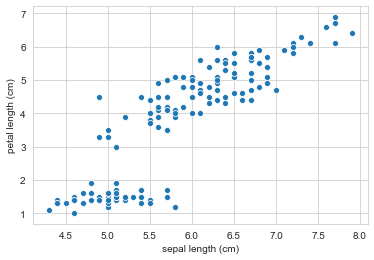

In [4]:
sns.set_style('whitegrid')

sns.scatterplot(data['sepal length (cm)'], data['petal length (cm)'])